# Predecir mutaciones cancerosas a partir de imágenes de células humanas

## Metas (4 min)

En casos anteriores, aprendimos los fundamentos de una red neuronal artificial (ANN) y vimos cuán poderosos podían ser para analizar datos complejos, especialmente grandes conjuntos de datos con relaciones altamente no lineales.

Sin embargo, todavía estábamos trabajando con datos tradicionales compuestos por vectores de características estructurados. En este caso, aprenderá sobre un tipo particular de arquitectura de red neuronal, la **red neuronal convolucional**, que puede manejar datos más complejos, como imágenes. Aprenderá no solo la estructura de este tipo de modelo, sino también cómo entrenarlo y evaluarlo utilizando una caja de herramientas moderna de ciencia de datos. También podrá evaluar las fortalezas y limitaciones de su CNN en comparación con modelos más simples y ganar experiencia con TensorFlow y Keras.

In [1]:
### Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# general
from numpy import mean
from numpy import std
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

# Procesamiento de imagenes
from PIL import (
    Image,
)  # <-- if you cannot install, comment out and find the cell containing %%help%%

# import pickle  # <-- these packages are optional, only if you want to explore image processing
# import glob
# import os

# redes neuronales convolutionales
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

# random forest
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use("ggplot")

## Introduction (10 min)

<img src=files/hook.jpg width="500">

**Contexto empresarial.** Trabaja para un grupo de investigación médica que trabaja para desarrollar un método de diagnóstico que identifica la **predisposición al cáncer** de un individuo en función de imágenes de células humanas.

Esta herramienta podría ser revolucionaria para identificar mutaciones específicas en el gen p53 asociado al cáncer sin pruebas genéticas; el procedimiento podría ser mucho más barato y menos invasivo. Además, si entendemos qué características de las imágenes se están utilizando para distinguir las células mutantes, esto podría ayudar a generar más hipótesis y experimentos sobre las diferencias biológicas subyacentes para ayudar a determinar la predisposición de una persona.

Hay tres tipos diferentes de mutaciones que desea poder detectar, basándose en cientos de imágenes de células fotografiadas bajo un microscopio. También debe poder detectar si existe una mutación.

**Problema comercial.** Se le ha encomendado **predecir la mutación de una célula, dada cualquier información que pueda obtener de estas fotografías**. Específicamente, utilizará imágenes sin procesar de células de fibroblastos humanos y características extraídas de estas imágenes mediante algoritmos de procesamiento de imágenes.


**Contexto analítico.** En el último caso, se familiarizó con las redes neuronales básicas al predecir el valor justo de mercado de los automóviles usados. El conjunto de datos que usó fue algunos de los datos estructurados estándar que probablemente haya visto antes: características extraídas de Craigslist. En este caso, trabajará con datos de imágenes y aprenderá sobre redes neuronales más avanzadas: en particular, la **red neuronal convolucional** (CNN). Practicará el uso y la comparación de una variedad de clasificadores de aprendizaje automático, tanto tradicionales como más modernos, para abordar la pregunta: *¿Podemos predecir mutaciones cancerosas a partir de imágenes de células humanas?*

El caso está estructurado de la siguiente manera: (1) comprenderá el conjunto de datos de imágenes sin procesar; (2) construirás, entrenarás y evaluarás una CNN simple desde cero; (3) construirás, entrenarás y evaluarás una CNN más compleja usando el módulo `keras` de TensorFlow; y (4) creará, entrenará y evaluará un clasificador de aprendizaje automático más tradicional (bosque aleatorio) en un conjunto de características extraídas previamente de las imágenes sin procesar.

<img src=files/cellimage.jpg width="500">

En la imagen de arriba, puede ver una fotografía de células de fibroblastos de pulmón humano bajo un microscopio. El verde es el cuerpo (el citoplasma) de la célula y el rosa es el núcleo. La biotecnología ha avanzado para que podamos realmente "colorear" las células y fotografiarlas con microscopios de alta definición. También podemos hacer esto a gran escala, fotografiando miles de células a la vez. Hoy en día, los científicos pueden incluso colorear diferentes partes de una célula (como el núcleo de arriba, pero también otros orgánulos) haciendo que diferentes proteínas se iluminen con fotofluorescencia. Como en muchas otras industrias, esto ha llevado a una explosión de datos, porque ahora cada celda tiene innumerables características que podemos observar a partir de una sola imagen.

Lo que exploraremos en este caso es cómo trabajar con estos datos de imagen. Sin embargo, muchos de los desafíos que enfrentaremos en este caso no son exclusivos del problema de comprender las células; son útiles si alguna vez necesita trabajar con datos de imagen.

## Entendiendo la data (35 min)

### Preprocesamiento de imagenes (5 min)

Eche un vistazo a un ejemplo de una imagen sin procesar de cada clase en escala de grises (originalmente estaban en color). La primera imagen es de una celda con la primera mutación (las fotografías de las células se mejoran para refinar los bordes y disminuir el desenfoque). La siguiente imagen es un ejemplo de una célula con la segunda mutación. Luego hay un ejemplo de una celda con la tercera mutación, que es más débil porque provienen de un laboratorio que no realiza mejoras de imagen. Finalmente, hay un ejemplo de una célula donde no hay mutaciones. Estas muestras provienen de un laboratorio donde los bordes de las células están rodeados manualmente por un técnico.

Tenga en cuenta el uso de [plt.subplot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) para mostrar varias imágenes en el mismo gráfico.

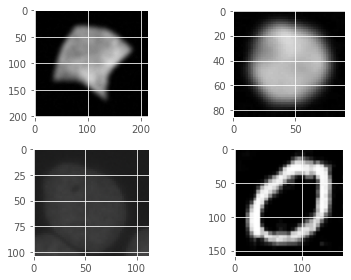

In [2]:
# %%help%% si tienes problemas instalando PIL, puedes solo abrir las imagenes
# en el directorio sample_images se pueden ver, en lugar de utilizar este codigo

sample_images_path = "sample_images/"
sample_images_list = ["mut_1", "mut_2", "mut_3", "normal"]
for i, img in zip(range(len(sample_images_list)), sample_images_list):
    pil_im = Image.open(sample_images_path + img + ".png", "r")
    # plot raw pixel data,
    plt.subplot(2, 2, 1 + i)
    plt.imshow(np.asarray(pil_im), cmap="Greys")
plt.tight_layout()
plt.show()

En aras del tiempo, trabajaremos con un conjunto de datos preprocesado de las imágenes. El bloque de código a continuación muestra algunas de las transformaciones que se realizaron en los archivos PNG sin procesar. Como esto ya se ha ejecutado, no es necesario volver a ejecutar este código, y está "bloqueado" detrás de una instrucción `if False`.

Observe que cambiamos el tamaño, centramos y escalamos las imágenes y también ajustamos algunas diferencias de contraste, pero no ajustamos el desenfoque. Intente pensar cuáles podrían ser las implicaciones de algunas de estas decisiones:

In [3]:
## funcion para hacer el resize de las imagenes, preservando el aspect ratio

run_preprocessing = False
if run_preprocessing:

    def resizeAspect(im, size):
        w, h = im.size
        aspect = max(size[0] / float(w), size[1] / float(h))
        return im.resize((int(w * aspect), int(h * aspect)), Image.ANTIALIAS)

    data_path = "raw_images/"
    imgList = glob.glob(data_path + "*.png")  # Encontrar a todas las imagenes png en el directorio

    num = 0
    for img in imgList:  # loop por todas las imagenes
        im = Image.open(img)  # abrir la imagen
        print("resizing:", os.path.basename(img))
        w, h = im.size  # tomar de la imagen el ancho y el alto
        if min(w, h) > 28:  # Chequear si cada dimension es mayor a 50
            im = resizeAspect(im, (28, 28))  # re-size de la imagen
            w, h = im.size  # hacer el update de la imagen
        center = [int(w / 2.0), int(h / 2.0)]  # calculatar el centroide
        box = (
            center[0] - 14,
            center[1] - 14,
            center[0] + 14,
            center[1] + 14,
        )  # definir el box 
        croppedIm = im.crop(box)  # cortar la imagen
        # croppedIm.show()                           # mostrar la imagen cortada
        print(croppedIm.size)
        fileName, fileExtension = os.path.splitext(img)
        croppedIm.save(
            "images/" + fileName[len(data_path) :] + "_crop.png", "PNG"
        )  # guardar la imagen recortada

### Imagenes en CSV (5 min)

Una vez finalizado todo el preprocesamiento, podemos cargar nuestros datos de imagen a través de un archivo CSV y echar un vistazo a nuestras imágenes ajustadas. Todas las dimensiones son iguales y se han corregido algunas de las diferencias de contraste.

Si está acostumbrado a tratar con imágenes como archivos individuales (por ejemplo, archivos `.png`), puede parecer extraño pensar en almacenar imágenes en un archivo `.csv`. Sin embargo, el concepto detrás de esto es simple. Cada una de nuestras imágenes está compuesta por 28x28 píxeles, que son 784 píxeles en total. Cada imagen en `data/all_dat.csv` está representada por una fila con 785 columnas
   
La primera columna es la etiqueta de clasificación de cada imagen. Específicamente, es `0` para las células "normales" y `1`,`2` o`3` para los tipos de mutación 1, 2 y 3, respectivamente. Las siguientes 784 columnas representan el valor de la escala de grises (los valores más bajos son más oscuros) de cada píxel. Por lo tanto, tenemos 1200 muestras (filas) con 784 columnas cada una.

In [3]:
# Mirar las dimensiones de la data 
all_dat = np.asfarray(pd.read_csv("data/all_dat.csv"))

# La primera columna representa los labels 
all_imgs = np.asfarray(all_dat[:, 1:])
all_labels = np.asfarray(all_dat[:, :1])

print(all_imgs.shape)
print(all_labels.shape)

(1200, 784)
(1200, 1)


In [4]:
# Mirar las primeras imagenes 
pd.DataFrame(all_imgs).head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922
1,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922
2,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922
3,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922
4,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922


### Graficar las imagenes desde el csv (15 min)

Debido a que cada imagen se almacena en una sola fila, si realmente queremos verlas como imágenes en lugar de texto, necesitamos "remodelarlas" en una matriz 2D de 28x28 y especificar que están definidas como píxeles en escala de grises.
    
Un ejemplo de visualización de una sola imagen es el siguiente:

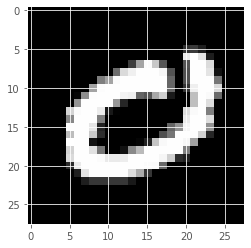

In [5]:
# reshape a 28x28 pixels
img = all_imgs[0].reshape((28,28))

# display la imagen,haciendo el mapping de cada pixel a la escala de colores "greys" 
plt.imshow(img, cmap="Greys")
plt.show()

### Ejercicio 1: (15 min)

Trace una cuadrícula de imágenes con cuatro filas, una para cada tipo de muestra. En cada fila, muestre una muestra aleatoria del conjunto de datos CSV de células con ese tipo de mutación.

**Respuesta.**

Type: 0


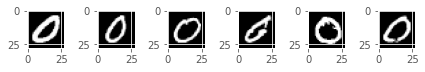

Type: 1


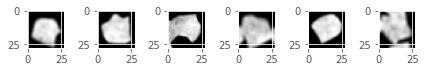

Type: 2


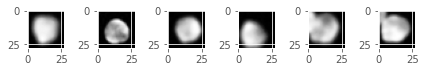

Type: 3


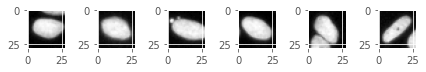

In [9]:
import random

# poner una semilla para tener resultados reproducibles
random.seed(1337)

# Separar las celdas en diferentes tipos de mutacion, mantenidneo los indices 
no_mutation_i = [i for i, x in enumerate(all_labels) if x == 0]
m1_i = [i for i, x in enumerate(all_labels) if x == 1]
m2_i = [i for i, x in enumerate(all_labels) if x == 2]
m3_i = [i for i, x in enumerate(all_labels) if x == 3]
mutation_types = [no_mutation_i, m1_i, m2_i, m3_i]

# Hacer el plot de 5 imagenes para cada tipo 
sample_size = 6

for row, mutation_type in enumerate(mutation_types):
    print("Type: {}".format(row))
    sample = random.sample(mutation_type, sample_size)
    for i, x in enumerate(sample):
        img = all_imgs[x]
        img = img.reshape((28, 28))
        plt.subplot(row +1, sample_size, 1 + i)
        plt.imshow(img, cmap="Greys")
    plt.tight_layout()
    plt.show()

Esto debería brindarle una comprensión intuitiva de lo que el algoritmo de aprendizaje automático necesita aprender para poder distinguir entre los diferentes tipos de células. Incluso si no somos expertos, podemos ver que los tipos de mutación parecen bastante distintos entre sí, por lo que no debería ser demasiado difícil para un clasificador distinguirlos.

### Preprocesar la data (10 min)
Antes de comenzar con la construcción de nuestros modelos, queremos dividir el conjunto de datos en un tren y un conjunto de prueba, y codificar las etiquetas de forma directa.

### Ejercicio 2: (10 min)

Divida el conjunto de datos de manera que el 90% de los datos se use para entrenamiento y el 10% de los datos se reserve para pruebas. Debe "estratificar" aún más los datos para que la misma proporción de cada tipo de celda esté presente en los conjuntos de entrenamiento y prueba.

**Sugerencia:** Puede pasar `estratificar` a la función de sklearn [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) a través de una representación de codificación one-hot :

```
label 0 in one-hot representation: [1 0 0 0]
label 1 in one-hot representation: [0 1 0 0]
label 2 in one-hot representation: [0 0 1 0]
label 3 in one-hot representation: [0 0 0 1]
```

**Respuesta.**

In [10]:
# split el dataset
X_train, X_test, y_train, y_test = train_test_split(
    all_imgs, all_labels, test_size=0.1, stratify=all_labels, random_state=13
)

no_of_different_labels = 4  #  i.e. 0, 1, 2, 3 mutations

train_imgs = X_train
test_imgs = X_test
train_labels = y_train
test_labels = y_test

In [11]:
lr = np.arange(no_of_different_labels)

# Transformar los lables en la representacion one-hot
train_labels_one_hot = (lr == train_labels).astype(np.float)
test_labels_one_hot = (lr == test_labels).astype(np.float)


In [12]:
# configurar algunos nombres de variables de atajo útiles
image_size = 28  # width and length
image_pixels = image_size * image_size

# Esto no es necesario, pero si es util si quieres guardar la data y reusarla despues
## Este codigo guarda la data en formalo .pkl para usarla mas facil dentro de Python o
# with open("data/pickled_dat.pkl", "bw") as fh:
#    data = (train_imgs,
#            test_imgs,
#            train_labels,
#            test_labels,
#            train_labels_one_hot,
#            test_labels_one_hot)
#    pickle.dump(data, fh)

# image_size = 28  # width and length
# image_pixels = image_size * image_size

## Creación y entrenamiento de una red neuronal desde cero (45 min)

Construyamos ahora una red neuronal simple de una sola capa y una sola época desde cero (usando solo `numpy` y` scikit-learn`) y entrenemos usando las imágenes sin procesar. En el caso anterior, recuerde que usamos la funcionalidad [`Sequential`](https://keras.io/guides/sequential_model/) de [` keras`](https://keras.io/)). Usaremos más herramientas listas para usar más adelante en este caso, pero para asegurarnos de que comprende cómo funcionan las redes neuronales, es bueno que construya una simple usted mismo.

Construiremos una red neuronal muy básica desde cero en la clase `NeuralNetwork`. Puede encontrar un código esqueleto para esta clase a continuación.


```
class NeuralNetwork:
    
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    def create_weight_matrices(self):
        ...
        
    def train(self, input_vector, target_vector):
        ...
        
    def run(self, input_vector):
        return ...
            
    def confusion_matrix(self, data_array, labels):
        return ...
    
    def evaluate(self, data, labels):
        return ...
```



También agregaremos las funciones `precision` y `recall` por conveniencia.

Para las redes neuronales completamente conectadas, hay tres preguntas esenciales que definen la **arquitectura** de la red:

1. ¿Cuántas capas hay?
1. ¿Cuántos nodos hay en cada una de esas capas?
1. ¿Qué función de activación se utiliza en cada una de esas capas?

Recuerde que existe una función de activación (generalmente la función de regresión logística) entre cada par de capas, lo que permite que nuestra red desarrolle sensibilidades no lineales. Cuando hay varias capas, podemos seguir agregando más combinaciones lineales de los nodos, lo que conducirá a modelos no lineales más complejos. Ya vimos la función de activación no lineal simple *ReLu*. En este caso, también usaremos la *función sigmoide* como función de activación, pero la clave a recordar es que hay [muchas funciones de activación diferentes](https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/) y la estructura y las limitaciones de su problema lo guiarán sobre cuál es mejor usar. Por ejemplo, la tarea de clasificación de imágenes en cuestión hace que ReLU sea una buena opción para nosotros debido a su eficiencia.

### Ejercicio 3: (5 min)

Escribe las funciones de activación `sigmoid` y` relu`. A continuación se muestra un código esqueleto.


```
def sigmoid(x):
    """
    Sigmoid function (decays exponentially at the tails).
    """
    return ???

def relu(x):
    """
    Rectified linear unit function (negative elements set exactly to zero).
    """
    return ???
```

**Respuesta.**

In [13]:
@np.vectorize
def sigmoid(x):
    """
    Sigmoid function (decays exponentially at the tails).
    """
    return 1 / (1 + np.e ** -x)

@np.vectorize
def relu(x):
    """
    Rectified linear unit function (negative elements set exactly to zero).
    """
    return np.maximum(x, 0)

Observe el símbolo `@` en la solución: esto indica que la función que sigue es un decorador de Python, que puede hacer que los cambios de función sean más fáciles de implementar y más legibles. Puede obtener más información [aquí](https://stackoverflow.com/questions/19844177/what-does-the-symbol-do-in-ipython-python). Ahora, tracemos las funciones de activación para que podamos examinar sus diferencias visualmente. La función ReLu debería resultarle familiar:

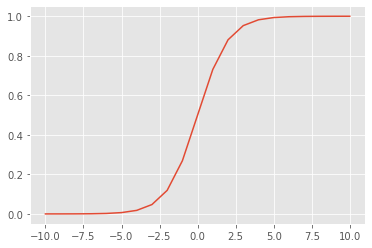

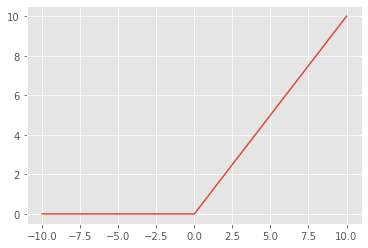

In [14]:
def plot_activation_function(activation_function):
    """
    Hacer el grafico de la funcion de activacion dada
    dominio (-10, 10).
    """
    # define a series of inputs
    series_in = [x for x in range(-10, 11)]
    # calculate outputs for our inputs
    series_out = [activation_function(x) for x in series_in]
    # line plot of raw inputs to rectified outputs
    plt.plot(series_in, series_out)
    plt.show()
    
plot_activation_function(sigmoid)
plot_activation_function(relu)

Una parte crucial de nuestra clase `NeuralNetwork` son los parámetros de red, las` weight_matrices`. Nuestra función `train` debe aprender cuál es el contenido de estas matrices de peso, y la función `run` luego aplicará esos pesos a la nueva entrada (por ejemplo, datos de prueba). Si tiene conocimientos en matemáticas, aquí hay una notación para ayudarlo a comprender cómo se actualizan los valores de los nodos con pesos y funciones de activación.

En la capa $\ell$ de la red, para $\ell=1,\ldots,L$, defina:

* $n_\ell$ como el número de nodos en la capa
* $W_\ell$ como matriz de peso
* $W_{\ell,jk}$ como el peso del nodo $j$ en la capa $\ell-1$ al nodo $k$ en la capa $\ell$
* $a_\ell$ como vector de activación, donde $a_{\ell,j}$ es la activación producida por el nodo $j$ en la capa $\ell$
* $a_0$ es el vector de entrada
* $b_\ell$ es el sesgo

Denotaremos $z_\ell = W_\ell^T a_{\ell-1} + b_\ell$ por conveniencia. En una red neuronal tenemos la siguiente relacion de recurrencia

$$a_\ell = \phi(W_\ell^T a_{\ell-1} + b_\ell) = \phi(z_\ell),$$

$$a_0 = x,$$

para todas las capas $\ell = 1, \ldots, L$. 

Ej: La activacion $a_\ell$ en la capa $\ell$ es la suma de del producto punto de los pesos con las activaciones en la capa previa $a_{\ell-1}$ y el parametro de sesgo.

Esto lo ayudará más adelante a completar los espacios en el código esqueleto. Tenga en cuenta que el parámetro de sesgo se puede ignorar por simplicidad. Puedes leer más sobre ellos [Aqui](https://medium.com/deeper-learning/glossary-of-deep-learning-bias-cf49d9c895e2).)

### Ejercicio 4: (30 min)

A estas alturas, debería tener la mayoría de las piezas que necesita para construir su propia red neuronal desde cero. Intente completar el código esqueleto para la `class NeuralNetwork` proporcionado anteriormente. Si necesita ayuda, consulte los ejemplos dados [Aqui](https://www.python-course.eu/neural_network_mnist.php).

**Respeusta.**

In [15]:
activation_function = sigmoid

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


class NeuralNetwork:
    def __init__(
        self, no_of_in_nodes, no_of_out_nodes, no_of_hidden_nodes, learning_rate
    ):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate
        self.create_weight_matrices()

    def create_weight_matrices(self):
        """ 
        metodo para inicializar la matriz de peso de la red 
        """
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, self.no_of_hidden_nodes))

    def train(self, input_vector, target_vector):
        """
        metodo para entrenar la red neuronal con el  input_vector
        con el output being target_vector
        """
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T

        output_vector1 = np.dot(self.wih, input_vector)
        output_hidden = activation_function(output_vector1)

        output_vector2 = np.dot(self.who, output_hidden)
        output_network = activation_function(output_vector2)

        output_errors = target_vector - output_network

        # Actualizar los pesos :
        tmp = output_errors * output_network * (1.0 - output_network)
        tmp = self.learning_rate * np.dot(tmp, output_hidden.T)
        self.who += tmp

        # calcular los hidden errors:
        hidden_errors = np.dot(self.who.T, output_errors)
        # actualizar los pesos :
        tmp = hidden_errors * output_hidden * (1.0 - output_hidden)
        self.wih += self.learning_rate * np.dot(tmp, input_vector.T)

    def run(self, input_vector):
        """
        metodo para correr la red neuronal con input_vector
        usando las matrices de pesos aprendidas
        """
        # input_vector puede ser una tupla, lista o ndarray
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, input_vector)
        output_vector = activation_function(output_vector)

        output_vector = np.dot(self.who, output_vector)
        output_vector = activation_function(output_vector)

        return output_vector

    def confusion_matrix(self, data_array, labels):
        cm = np.zeros((4, 4), int)
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm

    def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()

    def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()

    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

## Usando la red neuronal que hemos contruido (25 min)

Ahora que tenemos nuestra propia clase de `NeuralNetwork`, es hora de probarlo en nuestro problema.


### Ejercicio 5: (25 min)

#### 5.1 (10 min)

Cree una instancia de la red, entrénela en el conjunto de datos de entrenamiento (mostrándole cada ejemplo de entrenamiento solo una vez) y obtenga que prediga la etiqueta para cada uno de los primeros 10 ejemplos en el conjunto de datos de prueba, así como la confianza de la predicción. Utilice valores adecuados para la tasa de aprendizaje y el número de nodos ocultos según su experiencia en casos anteriores.

**Respuesta.**

In [16]:
ANN = NeuralNetwork(
    no_of_in_nodes=image_pixels,
    no_of_out_nodes=4,  # esto corresponde al numero de labels 
    no_of_hidden_nodes=128,
    learning_rate=0.01,
)

In [17]:
for i in range(len(train_imgs)):
    ANN.train(train_imgs[i], train_labels_one_hot[i])

print("true | pred |  P()")
print("_____________________")
for i in range(10):
    res = ANN.run(test_imgs[i])
    print(
        " ",
        int(test_labels[i][0]),
        " | ",
        np.argmax(res),
        "  | ",
        round(np.max(res), 3),
    )

true | pred |  P()
_____________________
  2  |  3   |  0.414
  3  |  3   |  0.533
  2  |  3   |  0.443
  0  |  0   |  0.952
  3  |  3   |  0.514
  2  |  3   |  0.378
  2  |  2   |  0.322
  2  |  3   |  0.384
  0  |  0   |  0.915
  1  |  3   |  0.319


#### 5.2 (10 min)

Ahora evalúe la red en el tren y pruebe los conjuntos de datos e imprima una matriz de confusión. Describe tus resultados.

**Respuesta.**

In [18]:
corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
print("accuracy train: ", round(corrects / (corrects + wrongs), 3))
corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
print("accuracy test:  ", round(corrects / (corrects + wrongs), 3))

print("")
print("confusion matrix:")
cm = ANN.confusion_matrix(train_imgs, train_labels)
print(cm)

print("")
for i in range(4):
    print(
        "mutant " + str(i) + ",",
        "precision: ",
        round(ANN.precision(i, cm), 2),
        " recall: ",
        round(ANN.recall(i, cm), 2),
    )

accuracy train:  0.564
accuracy test:   0.558

confusion matrix:
[[270   0   0   0]
 [  0   0   0   0]
 [  0  70  69   0]
 [  0 200 201 270]]

mutant 0, precision:  1.0  recall:  1.0
mutant 1, precision:  0.0  recall:  nan
mutant 2, precision:  0.26  recall:  0.5
mutant 3, precision:  1.0  recall:  0.4


<ipython-input-15-dde60ea73bec>:86: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_matrix[label, label] / row.sum()


Podemos ver que la red identifica fácilmente los casos sin mutación pero que tiene más dificultad para distinguir entre las diferentes mutaciones. Tenga en cuenta que la red lucha particularmente con la mutación 1. En general, obtenemos alrededor del 60% de precisión tanto para los conjuntos de datos de prueba como de train. Dado que la precisión de referencia sería del 25% (ya que tenemos cuatro clases), este es un resultado razonablemente bueno, pero esperábamos que fuera mayor, especialmente para el conjunto de datos de entrenamiento, dado que la tarea no parecía demasiado difícil.

#### 5.3 (5 min)

Como sabe por casos anteriores, las redes neuronales se benefician de ver ejemplos más de una vez en varias épocas. Entrene a la red de nuevo, pero esta vez durante 30 épocas, y vea si los resultados son mejores. Una vez más, describe tus resultados.

**Sugerencia:** La red neuronal que construimos no tiene la funcionalidad de época incorporada, pero puede ejecutar un simple bucle `for` para mostrarle el conjunto de datos muchas veces. Debe generar el train y probar la precisión después de cada época.

**Respuesta.**

In [19]:
epochs = 30

for epoch in range(epochs):
    print("epoch:", epoch)
    for i in range(len(train_imgs)):
        ANN.train(train_imgs[i], train_labels_one_hot[i])

    corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
    print("accuracy train: ", round(corrects / (corrects + wrongs), 3))
    corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
    print("accuracy test:  ", round(corrects / (corrects + wrongs), 3))

epoch: 0
accuracy train:  0.718
accuracy test:   0.708
epoch: 1
accuracy train:  0.734
accuracy test:   0.717
epoch: 2
accuracy train:  0.738
accuracy test:   0.733
epoch: 3
accuracy train:  0.744
accuracy test:   0.733
epoch: 4
accuracy train:  0.756
accuracy test:   0.742
epoch: 5
accuracy train:  0.772
accuracy test:   0.75
epoch: 6
accuracy train:  0.787
accuracy test:   0.75
epoch: 7
accuracy train:  0.798
accuracy test:   0.758
epoch: 8
accuracy train:  0.806
accuracy test:   0.742
epoch: 9
accuracy train:  0.816
accuracy test:   0.758
epoch: 10
accuracy train:  0.82
accuracy test:   0.775
epoch: 11
accuracy train:  0.821
accuracy test:   0.775
epoch: 12
accuracy train:  0.827
accuracy test:   0.775
epoch: 13
accuracy train:  0.833
accuracy test:   0.775
epoch: 14
accuracy train:  0.838
accuracy test:   0.775
epoch: 15
accuracy train:  0.843
accuracy test:   0.775
epoch: 16
accuracy train:  0.848
accuracy test:   0.792
epoch: 17
accuracy train:  0.85
accuracy test:   0.792
epoch:

Con más épocas, la red neuronal comienza a funcionar mejor. Si bien la precisión del conjunto de entrenamiento todavía está mejorando en este punto a medida que la red neuronal comienza a "memorizar" el conjunto de entrenamiento, la precisión de la prueba no parece mejorar por encima del 80%, aunque esto sigue siendo significativamente mejor que nuestro resultado anterior.

## Construir y entrenar una convolutional neural network (70 min)
Hay muchos factores que pueden contribuir al rendimiento de una red neuronal. Como se discutió en casos anteriores, estos incluyen qué función de pérdida se usa (utilizaremos [**categorical crossentropy**](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class)), con algoritmo de optimizacion(usaremos [**stochastic gradient descent**](https://keras.io/api/optimizers/sgd/)), cuántas épocas de entrenamiento se ejecutarán antes de detenerse y el tamaño del lote dentro de cada época. El rendimiento también está influenciado por la cantidad de capas ocultas.

Es posible que las redes neuronales normales no se adapten bien a imágenes completas. En nuestro conjunto de datos de células, las imágenes tenían originalmente un tamaño de 200x200x3 (200 de ancho, 200 de alto, 3 canales de color RGB), por lo que una sola neurona completamente conectada en la primera capa oculta de una red neuronal normal tendría 200x200x3 = 120.000 pesos. Esto es inmanejable; además, querríamos tener más de una neurona en nuestra red. Esta gran cantidad de parámetros conduciría a un sobreajuste, por lo que reducimos las imágenes a 28x28x1 para hacer factible una estructura completamente conectada. Recuerde que también aplanamos nuestras imágenes de entrada a un solo vector de longitud 784. Esto no es ideal ya que ofuscamos información sobre qué píxeles están uno al lado del otro.

### Entendiendo a las Convolutional Neural Networks (20 min)

**Convolutional neural networks (CNN)** aproveche el hecho de que la entrada consiste en imágenes, cuyas propiedades espaciales naturalmente limitan la arquitectura para mantener manejable el número de parámetros. En particular, a diferencia de una red neuronal normal, las capas de una CNN tienen neuronas dispuestas en 3 dimensiones: ancho, alto y profundidad. (Tenga en cuenta que la palabra profundidad aquí no se refiere al número total de capas en una red). Por ejemplo, nuestras imágenes de entrada originales eran de dimensiones 200x200x3 (ancho, alto, profundidad respectivamente), donde la profundidad se refiere a los 3 colores RGB canales. Las neuronas de una capa solo estarán conectadas a una pequeña región de la capa anterior, en lugar de a todas las neuronas. Gráficamente, las CNN se representan comúnmente mediante prismas rectangulares para mostrar que las neuronas están dispuestas en 3 dimensiones:

<img src=files/ann_v_cnn.png width="800">

A la izquierda, tenemos una red neuronal regular de 3 capas. A la derecha, tenemos una red neuronal convolucional. Una CNN organiza sus neuronas en tres dimensiones (ancho, alto, profundidad) como se visualiza en una de las capas. Cada capa de una CNN transforma el volumen de entrada 3D en un volumen de salida 3D de activaciones neuronales. En este ejemplo, la capa de entrada roja contiene la imagen, por lo que su ancho y alto serían las dimensiones de la imagen, y la profundidad sería 3 (por ejemplo, canales rojos, verdes y azules si se utilizan imágenes en color codificadas en RGB estándar).

Ahora que hemos visto la implementación de una red neuronal simple y completamente conectada, podemos construir una red más avanzada utilizando un paquete de software existente. Usaremos la funcionalidad `Sequential` incorporada de la biblioteca` keras` de Python para construir una red más avanzada.

Para determinar los hiperparámetros correctos para nuestra red neuronal, necesitaremos volver a ejecutar nuestra red neuronal con diferentes parámetros varias veces. Es útil si configuramos una model pipeline para facilitar este proceso. Aquí, creamos las funciones `load_dataset` y` prep_pixels` para facilitar la carga y preparación de los datos que necesitamos para el entrenamiento:

In [20]:
# load train and test dataset
def load_dataset():
    # Cargar el dataset
    all_dat = np.asfarray(pd.read_csv("data/all_dat.csv"))
    # La primera columna son los labels 
    all_imgs = np.asfarray(all_dat[:, 1:])
    all_labels = np.asfarray(all_dat[:, :1])

    # Hacer el split en train:test
    trainX, testX, trainY, testY = train_test_split(
        all_imgs, all_labels, test_size=0.1, stratify=all_labels, random_state=13
    )
    # reshape el dataset para tener un solo canal 
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode para los target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY


# scale los pixels
def prep_pixels(train, test):
    # convertir de integers a  floats
    train_norm = train.astype("float32")
    test_norm = test.astype("float32")
    # normalizar en el arango 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    #  devolver las imagene snormalizadas
    return train_norm, test_norm

Antes de comenzar a definir nuestra arquitectura de red neuronal, asegúrese de estar familiarizado con estos términos y parámetros clave. Debería estar familiarizado con algunos de ellos del caso anterior:

1. **optimizer**: El algoritmo de optimización utilizado para actualizar los pesos en el entrenamiento de redes neuronales. Un optimizador común es el descenso de gradiente estocástico (SGD).
1. **learning rate**: La influencia del gradiente en la actualización de los pesos de la red neuronal en cada paso. Los valores más pequeños corresponden a actualizaciones más pequeñas (más lentas); el valor predeterminado en `SGD` de `keras` es 0.01.
1. **momentum**: La influencia del cambio de peso del paso anterior en el siguiente peso; el valor predeterminado en `SGD` de `keras` es 0.0.
1. **loss function**: La función que determina cómo evaluar las predicciones del modelo frente a los datos etiquetados. Una función de pérdida común es [mean squared error](https://keras.io/api/losses/regression_losses/#mean_squared_error-function).

Sabemos que las CNN consisten en una pila de capas que detectan patrones cada vez más complejos, seguidas al final por un puñado de capas completamente conectadas que utilizan esos patrones para producir una decisión final:

<img src=files/conv_layers.png width="500">

Tomado de [Towards Data Science](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2).

En las CNN, las capas alternas de **convolución** y **agrupación(pooling)** sirven para extraer características de una imagen, comenzando con formas básicas (como líneas en orientaciones particulares) y luego expandiéndose a combinaciones complicadas de estas formas básicas. Al final, las capas completamente conectadas permiten que la red decida una categoría de clasificación basada en las características que han sido extraídas por capas anteriores.

Los diagramas de CNN mostrarán cómo la imagen original se vuelve progresivamente más estrecha y profunda, a medida que una capa se convoluciona con varios núcleos (expandiendo la profundidad) en una **capa de convolución** y luego se comprime mediante una **capa de agrupación(pooling)** (reduciendo la ancho). Lo que comienza como una imagen amplia con todos los píxeles originales se convierte en una capa profunda de características con menos información espacial. Entonces, ¿qué está sucediendo en estas capas de convolución cruciales?

Una **convolución** es una operación que extrae patrones de una imagen (también usamos la palabra para hablar sobre el resultado de dicha operación). Has visto cómo se puede representar una imagen como una gran matriz de números. Una convolución consiste en pasar una matriz más pequeña, llamada **filtro convolucional** (o **núcleo(kernel)**), sobre esta matriz. El filtro extrae características de la matriz grande. En cada ubicación, cada píxel del filtro se multiplica por el píxel correspondiente en la imagen, y los resultados se suman para producir un solo número, que se almacena en una nueva matriz llamada mapa de características. Esto es todo lo que necesitamos para comenzar a detectar bordes, líneas de orientaciones particulares y características más complejas.

Aquí hay una demostración de cómo se aplica el filtro, donde la pequeña matriz amarilla es el filtro, la matriz verde es la entrada y la matriz rosa es el mapa de características producido por la convolución:

<img src=files/convolution_schematic.gif width="400">

Tomado de [WildML](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/).

Las características que extrae un filtro dependen de los valores contenidos dentro de ese filtro. Confiamos en esto en nuestra CNN, ya que el proceso de entrenamiento ajusta los valores del filtro, que a su vez ajusta qué características se extraen. Por tanto, la operación de convolución combina la entrada y el filtro para producir una salida modificada (el mapa de características). Para leer más, eche un vistazo a [esto](http://datahacker.rs/edge-detection/).

Demostremos un ejemplo simple de cómo un filtro de convolución podría cambiar una imagen: aplicamos dos filtros 4 x 4 diferentes. Observe cómo el primero difumina la imagen mientras que el segundo resalta los bordes superior e inferior:

(-0.5, 27.5, 27.5, -0.5)

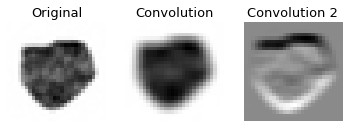

In [21]:
import scipy.ndimage as nd

# seleccionar una imagen random para manipular
img = all_imgs[400].reshape(28, 28)

conv_filter = np.array([[1,1,1,1], [1,1,1,1], [1,1,1,1], [1,1,1,1]])
conv_filter2 = np.array([[1,1,1,1], [0,0,0,0], [0,0,0,0], [-1,-1,-1,-1]])

image_new = nd.convolve(img, conv_filter)
image_new2 = nd.convolve(img, conv_filter2)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].set_title("Original", fontsize=13)
axes[0].axis("off")

axes[1].imshow(image_new, cmap=plt.cm.gray)
axes[1].set_title("Convolution", fontsize=13)
axes[1].axis("off")

axes[2].imshow(image_new2, cmap=plt.cm.gray)
axes[2].set_title("Convolution 2", fontsize=13)
axes[2].axis("off")


Una vez que hemos detectado varias características, en realidad no nos importa su ubicación precisa en la imagen. Queremos preservar cierta información espacial, pero nos preocupamos más por la presencia o ausencia de una característica y su ubicación *relativa* con respecto a otras.

Una forma de deshacerse de toda esa información espacial adicional es **agrupar(pool)** la capa. Esto significa dividir la capa en cuadrados que no se superpongan y realizar una operación que los agregue. La operación más común es simplemente generar el valor máximo encontrado dentro de esa región. Esto convierte una matriz grande en una matriz mucho más pequeña con los valores máximos de la anterior.

Al reducir la información espacial, tenemos menos cálculos que realizar y menos parámetros que podrían conducir a un sobreajuste. Cada paso de agrupación hace que la imagen sea más estrecha y, al mismo tiempo, conserva la profundidad:

<img src="files/conv_vs_pool.gif" width="500"/>

Tomado de [Becoming Human](https://becominghuman.ai/what-exactly-does-cnn-see-4d436d8e6e52).

Keras provee los layers que realizan el pooling operation - mirar [aqui](https://keras.io/api/layers/pooling_layers/). 

### Ejercicio 6: (15 min)

Escribir una funcion llamada `define_model()` que use Keras para crear un modelo `Sequential` con una convolutional layer. Keras provee [convolutional layers](https://keras.io/api/layers/convolution_layers/) en varias dimensiones (e.g. 1D, 2D, 3D) y debe elegir uno apropiado para la tarea.

**Sugerencia:** Piense en cuántas dimensiones tienen nuestras imágenes en escala de grises.

Debe intentar hacer esto sin ayuda, pero si necesita ayuda, puede echar un vistazo al código proporcionado. [here](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/) .

**Sugerencia:** Piense en la forma de los datos. Deberá pasar la `input_shape` apropiada a la capa convolucional según el tamaño de la imagen y terminar con una capa densa que esté relacionada con las dimensiones de las etiquetas.

**Respuesta.**

In [22]:
# definir el modelo cnn
def define_model():
    model = Sequential()
    model.add(
        Conv2D(
            8,
            (3, 3),
            activation="relu",
            kernel_initializer="he_uniform",
            input_shape=(28, 28, 1),
        )
    )
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(9, activation="relu", kernel_initializer="he_uniform"))
    model.add(Dense(4, activation="softmax"))
    
    # compilar el modelo
    opt = SGD(learning_rate=0.01, momentum=0.0)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

Tómese un momento para revisar el material sobre convolución, agrupación y las partes del código en `define_model`. Luego responda las siguientes preguntas para verificar su comprensión:

### Pregunta: (5 min)
En sus propias palabras, describa los parámetros **learning rate** y **momentum** y cómo los eligió.

El **learning rate** es un pequeño número positivo que controla la rapidez con la que el modelo se adapta a los errores en cada iteración de entrenamiento. Los valores más altos pueden ser ventajosos porque el aprendizaje ocurre "más rápido", pero también puede significar que el entrenamiento terminó con pesos inestables o subóptimos. Los valores más pequeños pueden ser ventajosos porque el aprendizaje es más preciso, pero también puede significar que el entrenamiento lleva mucho más tiempo (o no se capacita por completo). Desea probar diferentes valores de la tasa de aprendizaje para ver cuál funciona mejor para su problema. Puedes leer más sobre esto [aqui](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/).

El **momentum** es un hiperparámetro que controla en qué medida las ponderaciones del modelo se ven afectadas por las ponderaciones de la iteración anterior. El cambio de peso es igual a la tasa de aprendizaje multiplicada por el gradiente, más un factor de impulso multiplicado por el cambio de peso de la iteración anterior.

### Adcionar alguna funciones de ayuda (10 min)

Para evaluar y comprender mejor nuestra red neuronal, necesitaremos usar algunas funciones más.

Hay cierta aleatoriedad involucrada en el proceso de entrenamiento y este es un conjunto de datos pequeño, por lo que algunas ejecuciones pueden mostrar resultados más altos o más bajos y la media de una sola ejecución debe tomarse con cautela. Por esta razón, tenga en cuenta que ``evaluate_model`` utiliza $k$-fold [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) para garantizar que los resultados evaluados sean independientes del conjunto de prueba, dividiendo el conjunto de datos en conjuntos de $k$ y manteniendo uno como conjunto de prueba en cada iteración, entrenando en el resto.[StratifiedKfold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) asegura que las diferentes clases estén representadas proporcionalmente en cada conjunto:

In [23]:
# evaluatar al modelo usando k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # preparar cross validation
    kfold = StratifiedKFold(n_folds, shuffle=True, random_state=1)
    # enumerar los splits
    dataY_asfactor = [
        np.argmax(y) for y in dataY
    ]  # StratifiedKFold 
    for train_ix, test_ix in kfold.split(dataX, dataY_asfactor):
        # definir el modelo
        model = define_model()
        # seleccionar filar para train y test
        trainX, trainY, testX, testY = (
            dataX[train_ix],
            dataY[train_ix],
            dataX[test_ix],
            dataY[test_ix],
        )
        # ajustar el modelo
        history = model.fit(
            trainX,
            trainY,
            batch_size=3,
            epochs=30,
            validation_data=(testX, testY),
            verbose=False,
        )
        # evaluar el modelo
        y_pred = model.predict_classes(testX, verbose=False)
        y_true = [np.argmax(y) for y in testY]
        # print(confusion_matrix(y_true, y_pred))
        _, acc = model.evaluate(testX, testY, verbose=True)
        print("> %.3f" % (acc * 100.0))
        # guardar los scores
        scores.append(acc)
        histories.append(history)
    print("")
    print(model.summary())
    print("")
    return scores, histories

In [24]:
# Hacer el plot diagnostico de las curvas de aprendizaje 
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # graficar el loss
        plt.subplot(2, 1, 1)
        plt.title("Crossentropy Loss")
        plt.plot(histories[i].history["loss"], color="blue", label="train")
        plt.plot(histories[i].history["val_loss"], color="orange", label="test")
        # graficar el  accuracy
        plt.subplot(2, 1, 2)
        plt.title("Classification Accuracy")
        plt.plot(histories[i].history["accuracy"], color="blue", label="train")
        plt.plot(histories[i].history["val_accuracy"], color="orange", label="test")
        plt.tight_layout()
    plt.show()

In [25]:
# summary del model performance
def summarize_performance(scores):
    # print summary
    print("")
    print(
        "Accuracy: mean=%.3f, std=%.3f, n=%d"
        % (mean(scores) * 100, std(scores) * 100, len(scores))
    )
    # box y whisker plots de resultos
    plt.boxplot(scores)
    plt.show()

In [26]:
# correr el test harness para evaluar al modelo 
def run_test_harness(prep_pixels=False):
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # preparar la data pixelada
    if prep_pixels:
        trainX, testX = prep_pixels(trainX, testX)
    # evaluar el modelo
    scores, histories = evaluate_model(trainX, trainY, n_folds=10)
    print(scores)
    # learning curves
    summarize_diagnostics(histories)
    # summary del performance estimado
    summarize_performance(scores)

Con estos, ahora podemos ejecutar nuestra canalización de modelos completa, incluida la carga del conjunto de datos, el entrenamiento y la evaluación del modelo, y el resumen de los resultados, ejecutando la función `run_test_harness`.

### Ejercicio 7: (5 min)

Ejecute la canalización completa y describa los resultados.

**Respuesta.** 

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
4/4 [==============================] - 0s 4ms/step - loss: 0.2952 - accuracy: 0.8426
> 84.259
4/4 [==============================] - 0s 6ms/step - loss: 0.3653 - accuracy: 0.7500
> 75.000
4/4 [==============================] - 0s 5ms/step - loss: 0.4076 - accuracy: 0.7593
> 75.926
4/4 [==============================] - 0s 3ms/step - loss: 0.1279 - accuracy: 0.9444
> 94.444
4/4 [==============================] - 0s 3ms/step - loss: 0.3132 - accuracy: 0.8519
> 85.185
4/4 [==============================] - 0s 6ms/step - loss: 0.2946 - accuracy: 0.8426
> 84.259
4/4 [==============================] - 0s 3ms/step - loss: 0.1941 - accuracy: 0.9259
> 92.593
4/4 [===

<ipython-input-24-9806bd349b1c>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 1)
<ipython-input-24-9806bd349b1c>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 2)


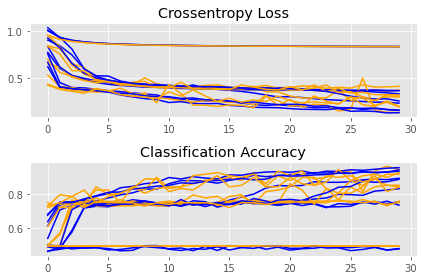


Accuracy: mean=78.333, std=15.428, n=10


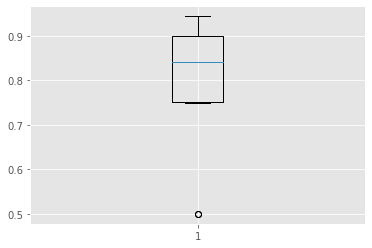

In [27]:
run_test_harness()

El entrenamiento es bastante inestable, con una precisión en el conjunto de entrenamiento que va desde el 50% hasta el 96% durante el proceso. Tampoco mostró una mejora constante con cada época, sino que subió y bajó de una época a otra.

Sin embargo, la precisión de la prueba final es mejor que la que logramos con nuestra red "desde cero".

### Ejercicio 8: (15 min)

Para mejorar el rendimiento de nuestro modelo, podríamos intentar modificar los hiperparámetros, como la tasa de aprendizaje. También podríamos intentar agregar más capas.

Modifique la función `define_model()` para intentar mejorar el modelo. Al menos deberías intentar agregar más capas convolucionales.

Describe tus resultados y compáralos con los anteriores.

**Respuesta.** A continuación se muestra una posible solución.

In [28]:
# definir el modelo cnn 
def define_model():
    model = Sequential()
    model.add(
        Conv2D(
            8,
            (3, 3),
            activation="relu",
            kernel_initializer="he_uniform",
            input_shape=(28, 28, 1),
        )
    )
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(4, (3, 3), activation="relu", kernel_initializer="he_uniform"))
    model.add(Conv2D(2, (3, 3), activation="relu", kernel_initializer="he_uniform"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(8, activation="relu", kernel_initializer="he_uniform"))
    model.add(Dense(4, activation="softmax"))
    # compilar el modelo
    opt = SGD()
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

4/4 [==============================] - 0s 3ms/step - loss: 0.2321 - accuracy: 0.8889
> 88.889
4/4 [==============================] - 0s 6ms/step - loss: 0.2511 - accuracy: 0.9259
> 92.593
4/4 [==============================] - 0s 3ms/step - loss: 0.3285 - accuracy: 0.8333
> 83.333
4/4 [==============================] - 0s 4ms/step - loss: 0.1464 - accuracy: 0.9630
> 96.296
4/4 [==============================] - 0s 4ms/step - loss: 0.1712 - accuracy: 0.9259
> 92.593
4/4 [==============================] - 0s 3ms/step - loss: 0.2189 - accuracy: 0.9074
> 90.741
4/4 [==============================] - 0s 4ms/step - loss: 0.2023 - accuracy: 0.9537
> 95.370
4/4 [==============================] - 0s 4ms/step - loss: 0.5826 - accuracy: 0.8148
> 81.481
4/4 [==============================] - 0s 4ms/step - loss: 0.1138 - accuracy: 0.9444
> 94.444
4/4 [==============================] - 0s 7ms/step - loss: 0.1565 - accuracy: 0.9444
> 94.444

Model: "sequential_19"
____________________________________

<ipython-input-24-9806bd349b1c>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 1)
<ipython-input-24-9806bd349b1c>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 2)


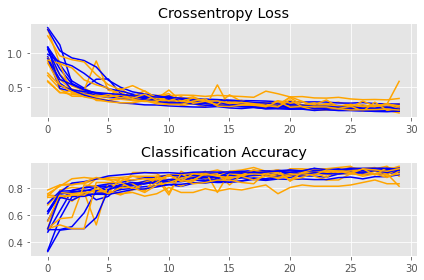


Accuracy: mean=91.019, std=4.794, n=10


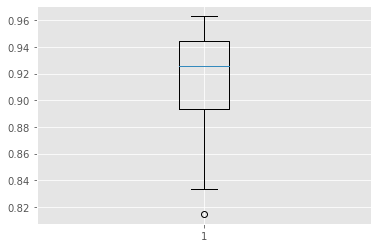

In [29]:
run_test_harness()

Con las capas adicionales, el modelo tardó un poco más en entrenarse, pero ahora alcanzamos alrededor del 89% de precisión, que es mejor que nuestro modelo más simple y sustancialmente mejor que nuestro modelo "desde cero".

## Uso de funciones extraídas previamente para entrenar algoritmos de aprendizaje automático más simples (35 min)

### Extraer mas features de nuestro dataset (5 min)

Como podemos ver, trabajar con imágenes en bruto puede resultar muy complicado. Por un lado, las imágenes contienen una gran cantidad de datos (una sola imagen en nuestro conjunto de datos tiene 784 píxeles, y esta es una resolución bastante *baja*); por otro lado, las imágenes también contienen mucho ruido y redundancia (por ejemplo, altas correlaciones espaciales, efectos aleatorios de la iluminación y el desenfoque). A menudo, cuando se trabaja con datos que tienen una relación señal/ruido baja, es útil utilizar un enfoque de preprocesamiento más mecanicista para transformar los datos en un subespacio que tiene una relación señal/ruido más alta. Estos pasos de preprocesamiento deben aplicar el conocimiento relevante específico del dominio a los datos con el fin de "concentrar" las partes clave de la señal. En nuestro ejemplo, los biólogos pueden examinar algunas docenas de imágenes y señalar características relevantes de las imágenes para distinguir entre diferentes mutaciones:

1. "Las células normales tienen una forma más elíptica".
2. "La segunda mutación parece tener células generalmente más oscuras y densas".
3. "La primera mutación da como resultado células con bordes más irregulares".
4. "Es de esperar que las células mutantes se agrupen más".

Cada una de estas observaciones humanas podría escribirse como una medida cuantitativa:

1. Forma
2. Color
3. Excentricidad
4. Proximidad

Los algoritmos de visión por computadora pueden traducir imágenes sin procesar en algunas de las características mencionadas en estas observaciones. Para nuestras imágenes, sabemos que hay un objeto de celda en el medio con un fondo oscuro. La separación de una imagen en varios segmentos (con suerte relevantes) se conoce como **segmentación de imágenes**. A continuación, se muestra un ejemplo de segmentación de imágenes para un automóvil autónomo:

<img src=files/self-driving-car.gif width="600">

A continuación, se muestra un diagrama de cómo se incorpora la segmentación de imágenes en una canalización de análisis de células:

<img src=files/cell_analysis_pipeline.png width="600">

El conjunto de datos que analizaremos en la siguiente parte del caso son 50 características extraídas automáticamente para cada celda en nuestro conjunto de datos de imágenes utilizando algoritmos de visión por computadora (personalizados para imágenes de células capturadas a través de microscopía fluorescente). Puede cargar el nuevo archivo CSV de la siguiente manera:

In [30]:
feature_dat = pd.read_csv("data/feature_dat.csv")
print(feature_dat.shape)
feature_dat.head()

(1200, 51)


,shape1,shape2,shape3,shape4,shape5,shape6,shape7,shape8,color1,color2,...,proxi2,proxi3,proxi4,proxi5,proxi6,proxi7,proxi8,hrlck1,hrlck2,mutation
0,-0.000002,-0.000006,0.000338,-6.223100e-06,5.723900e-05,0.000472,0.052716,0.052722,0.052383,0.095004,...,4.4449,0.836480,-1.5031,-1.5029,1.150963,1.670230,-1.4964,0.231260,4.662331,0
1,0.000023,0.000022,-0.000043,7.678700e-07,1.663000e-05,-0.000189,0.055287,0.055265,0.055308,0.071142,...,8.4147,1.839299,-1.5025,-1.5027,1.992683,2.807464,-1.5055,1.532233,5.196261,0
2,-0.000022,0.000004,0.000362,1.681700e-06,-1.189500e-05,-0.000167,0.006509,0.006505,0.006143,0.019397,...,5.7082,-0.575317,-1.4975,-1.4969,-1.057035,-1.575473,-1.4984,-1.846138,5.158199,0
3,0.000003,0.000005,0.000006,1.402100e-06,7.705300e-07,0.000008,0.059301,0.059296,0.059290,0.110130,...,2.8404,0.611047,-1.4967,-1.4967,1.118759,1.667009,-1.4972,1.995589,4.610642,0
4,-0.000008,-0.000049,0.000103,2.089200e-06,-9.886500e-05,-0.000121,0.010542,0.010591,0.010488,-0.020250,...,6.4415,1.607215,-1.5066,-1.5065,1.959528,2.804148,-1.4979,0.583515,4.916569,0


This is an example of how an image is translated into a few of the extracted features you see in the table:

<img src=files/cell_extraction.png width="800">

### Crear un clasificador con random forest (30 min)
Construyamos y entrenemos ahora clasificadores más simples en las características de ingeniería extraídas de las imágenes. Ahora que hemos transformado nuestras imágenes en un conjunto de datos más "clásico", podemos elegir un modelo de nuestro conjunto familiar de herramientas de clasificación.

### Ejercicio 9: (15 min)

Dividir el nuevo dataset en la misma forma que el anterior. Usar un [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) para escalar la data, y crear un modelo[`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) , entrenado con esta data escalada .Genere las matrices de precisión y confusión, así como la precisión y recuperación para cada tipo de celda. Describe los resultados.

**Respuesta.**

In [31]:
# recolectar la data en train:test split
X = feature_dat.drop("mutation", axis=1)
Y = feature_dat.mutation

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=13
)

# escalar los features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ajustar el  random forest classifier
classifier = RandomForestClassifier(
    n_estimators=10, criterion="entropy", random_state=13
)
classifier.fit(X_train, y_train)

# hacer las predicciones en el training set
y_pred_train = classifier.predict(X_train)
print("accuracy train: ", round(np.mean(y_pred_train == y_train), 2))

# predicciones en el test set
y_pred = classifier.predict(X_test)
print("accuracy test:  ", round(np.mean(y_pred == y_test), 2))

print("")
print("confusion matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("")
for i in range(4):
    print(
        "mutant " + str(i) + ",",
        "precision: ",
        round(ANN.precision(i, cm), 2),
        " recall: ",
        round(ANN.recall(i, cm), 2),
    )

accuracy train:  1.0
accuracy test:   0.88

confusion matrix:
[[34  2  0  1]
 [ 1 18  2  0]
 [ 2  4 21  1]
 [ 0  1  0 33]]

mutant 0, precision:  0.92  recall:  0.92
mutant 1, precision:  0.72  recall:  0.86
mutant 2, precision:  0.91  recall:  0.75
mutant 3, precision:  0.94  recall:  0.97


Con una precisión del 88%, el random forest en la nueva representación de nuestros datos funciona tan bien como la CNN, y también es significativamente más rápido.

Esto muestra que la ingeniería de características adecuada puede ser más importante que el uso de algoritmos avanzados. Las redes neuronales a menudo brillan para conjuntos de datos realmente grandes, mientras que los algoritmos más simples a menudo pueden funcionar igual o mejor en los más pequeños.

### Ejercicio 10: (15 min)

Usando el código anterior de una sola iteración del bosque aleatorio, escriba una función `evaluate_rfmodel` que sea muy similar a` evaluate_model` del arnés de prueba de la red neuronal. Cree un "StratifiedKFold" del conjunto de datos y ejecute múltiples iteraciones, creando un diagrama de caja para mostrar la precisión. Explica los resultados.


**Respuesta.**

> 98.333
> 97.500
> 98.333
> 98.333
> 96.667
> 100.000
> 98.333
> 99.167
> 98.333
> 97.500

Accuracy: mean=98.250, std=0.870, n=10


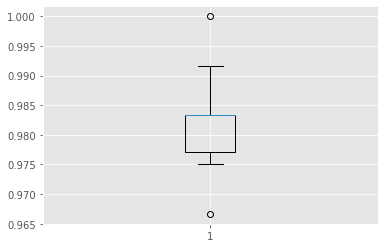

In [32]:
# evaluatar el modelo random forest usando el k-fold cross-validation
def evaluate_rfmodel(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # preparar el cross validation
    kfold = StratifiedKFold(n_folds, shuffle=True, random_state=1)
    # enumerar los splits
    for train_ix, test_ix in kfold.split(dataX, dataY):
        # definir el model
        model = RandomForestClassifier(
            n_estimators=10, criterion="entropy", random_state=13
        )
        # seleccionar filas y columnas para train y test
        trainX, trainY, testX, testY = (
            dataX[train_ix],
            dataY[train_ix],
            dataX[test_ix],
            dataY[test_ix],
        )
        # escalar los features
        scaler = StandardScaler()
        trainX = scaler.fit_transform(trainX)
        testX = scaler.transform(testX)
        # ajustar el modelo
        history = model.fit(X_train, y_train)
        # evaluar el model
        y_pred = model.predict(testX)
        y_true = testY
        # print(confusion_matrix(y_true, y_pred))
        acc = np.mean(y_pred == y_true)
        print("> %.3f" % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

scores, _ = evaluate_rfmodel(np.asarray(X), np.asarray(Y), n_folds=10)
summarize_performance(scores)

Con múltiples ejecuciones, podemos ver que el bosque aleatorio en realidad funciona mucho mejor que la CNN y también es más consistente.

## Para llevar (7 min)

En este caso, aprendimos sobre los desafíos de trabajar con datos de imágenes. Clasificar cientos de imágenes previamente limpiadas en cuatro categorías es una tarea relativamente estándar, sin embargo, aprendimos algunas lecciones importantes y también sobre desafíos adicionales que se manifiestan a medida que aumenta la complejidad. Si tenemos imágenes en bruto, más imágenes, imágenes más grandes, más clases o preguntas más inferenciales (frente a predictivas), este problema puede volverse aún más complicado. Aquí hay algunas conclusiones importantes de nuestro caso de hoy:

1. **Preprocessing, preprocessing, preprocessing.** La mayor parte de su tiempo lo dedicará a comprender y luego procesar sus datos sin procesar. Esto puede ser tan simple como recortar las imágenes o tan complejo como ajustar el color, el brillo, el desenfoque, etc. A menudo, se pueden lograr mejoras sustanciales en el rendimiento predictivo con un preprocesamiento más inteligente.
2. **Neural networks can be really useful... sometimes.** Nuestra comparación del rendimiento de la red neuronal con un clasificador de bosque aleatorio nos mostró que las redes neuronales no siempre tienen un rendimiento significativamente mejor. Es más prudente comenzar con los modelos más simples que pueda y solo comenzar a usar redes neuronales si tiene grandes conjuntos de datos y relaciones altamente no lineales.
3. **Convolutional neural networks can be useful when working with large signal data** (por ejemplo, imagen, audio, video). Aprendimos que las CNN son un tipo de red neuronal especialmente adaptada para trabajar con datos de entrada que son muy grandes y tienen algún tipo de estructura de dependencia (por ejemplo, espacial). Al igual que cualquier otro modelo, no siempre son útiles y pueden tener un rendimiento muy bajo en las configuraciones incorrectas, pero pueden producir muy buenos resultados en las correctas.

También conoció una gran cantidad de código nuevo en las bibliotecas de aprendizaje profundo hoy. Es mucho de digerir, así que revise el material técnico en este caso nuevamente en su propio tiempo para familiarizarse realmente con cómo implementar las CNN en la práctica.

### Apendice A: Un comentario sobre las CNN con imágenes de entrada de diferentes dimensiones.

En este caso, estaba trabajando con un conjunto de datos de imágenes preprocesado, donde las imágenes ya estaban hechas para tener el mismo tamaño y dimensiones. En la vida real, es posible que le entreguen un conjunto de datos mucho más desordenado donde las imágenes no tienen las mismas dimensiones, resolución o tamaño. Limpiarlos y procesarlos puede llevar un tiempo valioso en la ciencia de datos. Entonces, ¿esto importa?

### Pregunta Bonus:

¿Cuáles de los siguientes tipos de **capas** de redes neuronales son invariables con el tamaño de la imagen?

(a) fully-connected

(b) convolutional

(c) max-pooling

(d) batch normalization layers

**Respuesta.** 

Solo (a) **no** es invariante con el tamaño de la imagen. Todos los demás tipos de capas enumerados anteriormente pueden aceptar imágenes de cualquier dimensión. Aprende más [here](https://ai.stackexchange.com/questions/6274/convolutional-neural-networks-with-input-images-of-different-dimensions-image).

### Apendice B: Un comentario sobre las bibliotecas de aprendizaje profundo

Como científico de datos, debe estar familiarizado con diferentes bibliotecas de aprendizaje profundo. PyTorch y Tensorflow son dos de los marcos más populares. Inicialmente, Keras estaba separado de TensorFlow y proporciona un mayor nivel de abstracción para arquitecturas de red comunes. Ahora se incluye como parte de TensorFlow, ya que es muy popular en la industria, donde el uso de algoritmos probados es más importante que el desarrollo de nuevos.

<img src=files/keras_tensorflow_decision.png width="500">

### Apendice C: Un comentario sobre otras arquitecturas de redes neuronales

Existen docenas de otras arquitecturas (y los correspondientes algoritmos de aprendizaje) para diferentes tipos de datos, preguntas y limitaciones. No es necesario que los comprenda todos, pero debe estar al tanto de lo que hay ahí fuera:

<img src=files/chart_of_neural_networks.png width="700">

Tomado de [Stack Exchange](https://ai.stackexchange.com/questions/5546/what-is-the-difference-between-a-convolutional-neural-network-and-a-regular-neur).